# SaliencyMaps as a tool for interpretability in image classification tasks

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Overview

Neural networks are powerful tools, but they are **black-boxes**, meaning that it is difficult to provide human-understandable explanations on what they are doing. The field of **explanaibility** is concerned with finding algorithms for achieving this. 

The dataset has been found on [Kaggle](https://www.kaggle.com/datasets/anshtanwar/jellyfish-types) and it is in image dataset collecting a total of 900 pictures of different species of jellyfishes.

In particular these 600 images are of 6 different races of jellyfish (mauve stinger jellyfish, moon jellyfish, barrel jellyfish, blue jellyfish, compass jellyfish, and lion’s mane jellyfish) so this toy dataset is perfect for a classification task. The whole data loading pipeline was made leveraging Kaggle API on Google Colab and TensorFlow ```ImageDataGenerator``` from Keras preprocessing modules, so this notebook is meant to be run on Colab: you only need to provide a Kaggle token to activate the API.

In [ ]:
# TODO: Insert any data loading code here

# Libraries import
# File and system management
from google.colab import files
import os
import zipfile
import shutil

# Modules for some more visualization
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# TensorFlow specifics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [ ]:
os.makedirs(r'/content/Data')

# Upload the Kaggle token for API
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d anshtanwar/jellyfish-types

 67% 17.0M/25.5M [00:00<00:00, 42.7MB/s]
100% 25.5M/25.5M [00:00<00:00, 52.2MB/s]


In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!ls

Data  jellyfish-types.zip  kaggle.json	sample_data


In [ ]:
# Create a ZipFile Object and load sample.zip in it
with zipfile.ZipFile('jellyfish-types.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(r'/content/Data')

# Drop the ready-made folder with train-test split
shutil.rmtree(r'/content/Data/Train_Test_Valid')

In [ ]:
# Set the path to your dataset folders
base_path = r"/content/Data"

# Use ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2)

# Define batch size
batch_size = 32

# Create the training dataset
train_generator = datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),  # Adjust the target size as needed
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have multiple classes
    subset='training',
    shuffle=True,
    seed=4224
)

# Create the validation dataset
test_generator = datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=4224
)

Found 720 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In defining this model I tried to use some good thumb rules in convolutional neural networks:
+ In the convolutional block I started with filters with wide kernel and then gradually deployed smaller kernels: this in order to learn meaningful features in large images;

+ I increased the number of filters twicing them at each stacked convolutional layer;

+ I inserted a GlobalAveragingPooling layer to prevent the network from becoming too big;

+ I Inserted regularization tools, both an explicit $L_2$ regularizer in the dense layer and a Dropout layer.

Everything was defined through Keras modules and also the train phase has been done with Keras modules with a Stochastic Gradient Descent optimizer on the iterator provided by ImageDataGenerator, so I leveraged some TensorFlow peculiarities.

In [ ]:
# TODO: define a suitable neural network.

number_classes = 6
BATCH_SIZE = 32

model = keras.models.Sequential()

# First Conv2D layers with a subsequent MaxPooling layer
model.add(keras.layers.Conv2D(filters=16, kernel_size=(11,11), data_format='channels_last',activation='relu',use_bias=True,strides=4))
model.add(keras.layers.MaxPooling2D(data_format='channels_last',pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(7,7), data_format='channels_last',activation='relu',use_bias=True,strides=2))
model.add(keras.layers.MaxPooling2D(data_format='channels_last',pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(4,4), data_format='channels_last',activation='relu',use_bias=True))
model.add(keras.layers.MaxPooling2D(data_format='channels_last',pool_size=(2,2)))

# The global average pooling layer ensures that the number of parameters won't explode
model.add(keras.layers.GlobalAveragePooling2D())

# Since the following layer would have a high number of parameters, we introduced both a Ridge regularizer and a dropout layer
model.add(keras.layers.Dense(1024, activation='relu',kernel_regularizer=keras.regularizers.L2(l=0.1)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(number_classes, activation='softmax'))

# Compile before fitting the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.8,nesterov=True),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
# TODO: train the neural network.

# Define a custom callback to store batch-wise metrics
class BatchLossCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_accs = []
    def on_batch_end(self, batch, logs):
        self.batch_losses.append(logs['loss'])
        self.batch_accs.append(logs['categorical_accuracy'])

batch_loss_callback = BatchLossCallback()

train_history = model.fit(train_generator,
                          epochs=40,
                          batch_size=BATCH_SIZE,
                          verbose=1,
                          callbacks=[batch_loss_callback])

Epoch 1/40
23/23 [==============================] - 8s 308ms/step - loss: 11.9682 - categorical_accuracy: 0.1583
Epoch 2/40
23/23 [==============================] - 6s 260ms/step - loss: 8.2175 - categorical_accuracy: 0.2292
Epoch 3/40
23/23 [==============================] - 8s 351ms/step - loss: 5.7208 - categorical_accuracy: 0.2556
Epoch 4/40
23/23 [==============================] - 6s 252ms/step - loss: 4.1772 - categorical_accuracy: 0.2903
Epoch 5/40
23/23 [==============================] - 6s 249ms/step - loss: 3.1577 - categorical_accuracy: 0.3083
Epoch 6/40
23/23 [==============================] - 7s 268ms/step - loss: 2.5674 - categorical_accuracy: 0.3111
Epoch 7/40
23/23 [==============================] - 10s 456ms/step - loss: 2.1337 - categorical_accuracy: 0.3528
Epoch 8/40
23/23 [==============================] - 6s 271ms/step - loss: 1.9193 - categorical_accuracy: 0.3750
Epoch 9/40
23/23 [==============================] - 6s 257ms/step - loss: 1.7513 - categorical_accurac

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    5824      
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 16)    0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    25120     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, None, None, 32)    0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 64)    32832     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, None, None, 64)    0

#### Some metrics visualization: loss/accuracy in training and confusion matrix

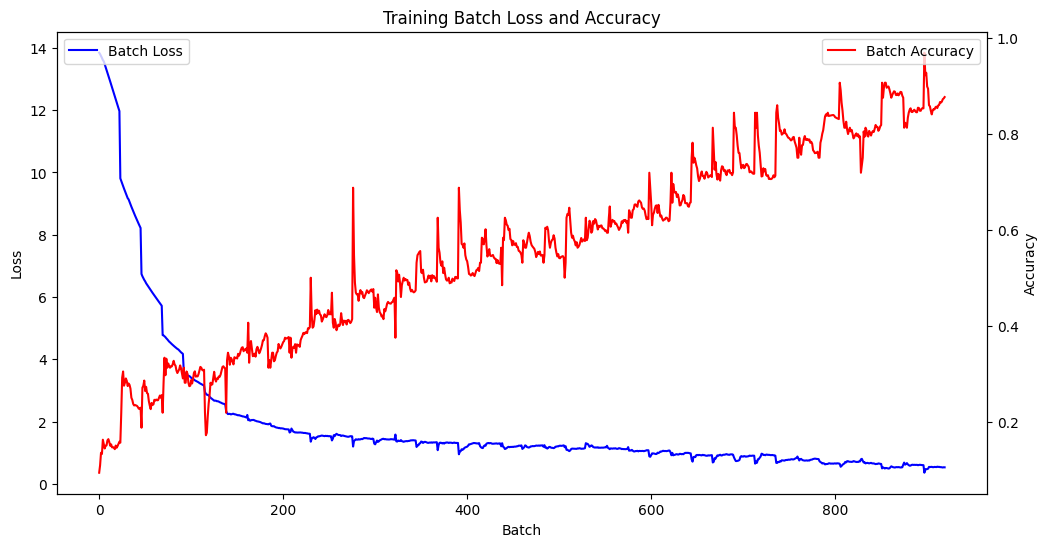

In [ ]:
# Access the stored batch losses and accuracies
batch_losses = batch_loss_callback.batch_losses
batch_accs = batch_loss_callback.batch_accs

# Plot both batch losses and accuracies in the same plot
plt.figure(figsize=(12, 6))

# Plot batch losses
plt.plot(batch_losses, label='Batch Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Create a second y-axis for batch accuracies
plt.twinx()
plt.plot(batch_accs, label='Batch Accuracy', color='red')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.title('Training Batch Loss and Accuracy')
plt.show()

6/6 [==============================] - 1s 67ms/step


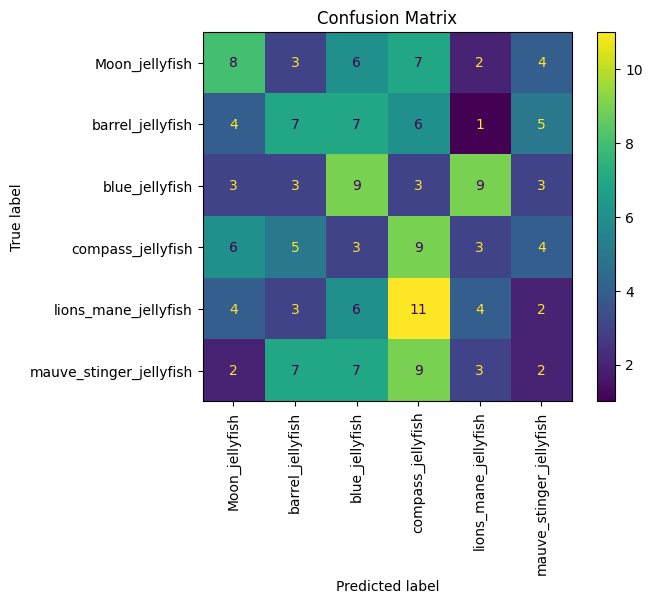

In [ ]:
# Get true labels
true_labels = test_generator.classes

# Get predicted labels
predicted_probabilities = model.predict(test_generator)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)


# Get class labels
classes = list(test_generator.class_indices.keys())

# Plot confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=classes)
disp.plot(cmap='viridis', values_format='d',xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Completion requirement

val_loss, val_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

5/5 [==============================] - 1s 117ms/step - loss: 1.0247 - categorical_accuracy: 0.7063
Validation Accuracy: 70.63%


### Vanilla saliency map

What do we mean by explainability? Consider the neural network $f(\cdot)$ you just trained, and a prediction $\hat{y} = f(x)$ we want to analyze. **Feature attribution** methods try to assign a weight $w_i$ to each input feature $x_i$, to understand which parts of the input have contributed the most to the explanation.

The simplest feature attribution technique, called **vanilla saliency map**, simply computes the gradient at that point:

$$
  S(x) = \left\lvert \frac{\partial f_c(x)}{\partial x} \right\rvert
$$

where  $c$ is the index corresponding to the predicted class.

In [ ]:
# Function for vanilla saliency map

@tf.function
def VanillaSaliencyMap(model, data_point):

        # We need to expand dimension on the input data point to match first layer dimension (batch dimension)
        data_point = tf.expand_dims(data_point, axis=0)

        # We need to istantiate a call to GradientTape and watch the input data_point
        with tf.GradientTape() as tape:
                tape.watch(data_point)

                # Compute the prediction
                pred = model(data_point, training=False)

                # Compute the predicted class
                C = int(tf.cast(tf.argmax(pred, axis=1)[0],'int32'))

                # Compute the vanilla saliency map
                return tf.math.abs(tape.gradient(pred[0,C],data_point))

In [ ]:
images_samples, labels_samples = next(test_generator)

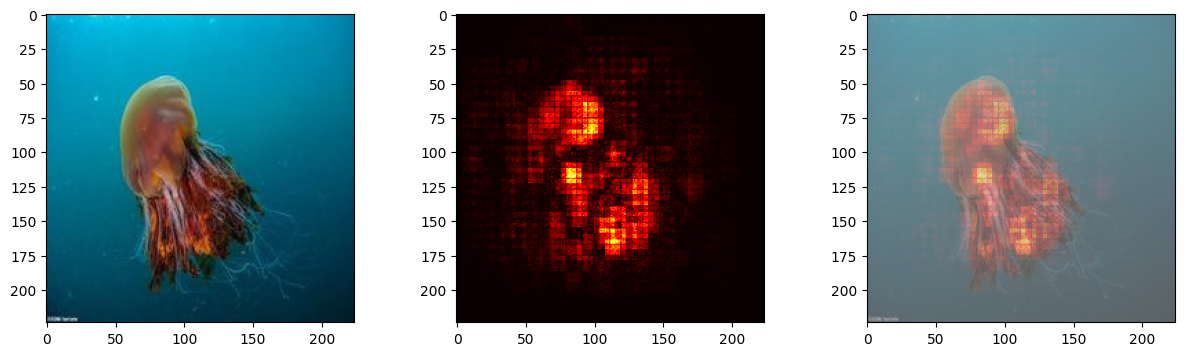

In [ ]:
# TODO: Check the saliency map to analyze the result. What can you say about the map?

sal_map = VanillaSaliencyMap(model, images_samples[1,:,:,:])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(images_samples[1,:,:,:])
axes[1].imshow(sal_map[0,:,:,0],cmap='hot')
axes[2].imshow(images_samples[1,:,:,:], alpha=0.5)
axes[2].imshow(sal_map[0,:,:,0],cmap='hot',alpha=0.3)

As a first assessment on the input the model seems to behave well on test data: what comes to mind when working with saliency maps is the image segmentation job, and in this case the model is quite good in discerning the object from the background. In terms of precision in classification:


In [ ]:
print(f'The true class is: {tf.cast(tf.argmax(labels_samples[0]),"int32")}')
print(f'The predicted class is: {int(tf.cast(tf.argmax(model(tf.expand_dims(images_samples[0], axis=0), training=False), axis=1)[0],"int32"))}')

The true class is: 2
The predicted class is: 2


So the model has been able to correctly classify and some zones of the images were more useful than others.

### Advanced saliency maps (1 point)

Saliency maps have several issues: most notably, they suffer from noise and they are not stable to small changes in the input or in the model (try running again the training and interpreting the same point). Many methods have been proposed to overcome this.

**[SmoothGrad](https://arxiv.org/abs/1706.03825)**, for example, computes multiple saliency maps from noisy versions of the input:

$$
  \text{SmoothGrad}(x) = \frac{1}{n}\sum_{i=1}^n S(x + \varepsilon_i), \;\; \varepsilon_i \sim \mathcal{N}(0, \sigma^2I)
$$

where $\varepsilon$ is a vector of the same shape as $x$, whose values are sampled from a normal distribution with zero mean and small variance.




In [ ]:
@tf.function
def SmoothGrad(model, data_point, noise_level, k=100):

    # Retrieve standard deviation corresponding to a certain level of noise
    sdv = tf.cast(noise_level*(tf.reduce_max(data_point)-tf.reduce_min(data_point)), 'float32')

    # Create gaussian noise matching the data_point dimensions
    size = data_point.shape
    noise = tf.random.normal((k, size[0], size[1], size[2]),stddev=sdv)
    noise = tf.cast(noise, 'float32')

    # We need to expand dimension on the input data point and tile the tensor to vectorize the operation
    data_point = tf.tile(tf.expand_dims(data_point, axis=0), [k,1,1,1])
    data_point = tf.cast(data_point, 'float32')

    # Now we can compute the saliency map with respect to each of the sample and then collapsing over the first dimension through averaging
    with tf.GradientTape() as tape:
        tape.watch(data_point)

        # Compute the noisy data
        noisy_data = tf.math.add(noise, data_point)

        # Compute the prediction
        preds = model(noisy_data)

        # Compute the predicted class
        C = tf.cast(tf.argmax(preds, axis=1), 'int32')

        # Slice the indices to get a mask for preds
        indices = tf.transpose(tf.stack([tf.range(k), C]))

        # Return the abs of the gradient of the output with respect to the data point
        C_preds = tf.gather_nd(preds, indices)

        return tf.reduce_mean(tf.math.abs(tape.batch_jacobian(tf.expand_dims(C_preds, axis=1),data_point)), axis=0)

Let's replicate the visualization we have in [2] for the previous input image and for two more samples with respect to different values for the noise:

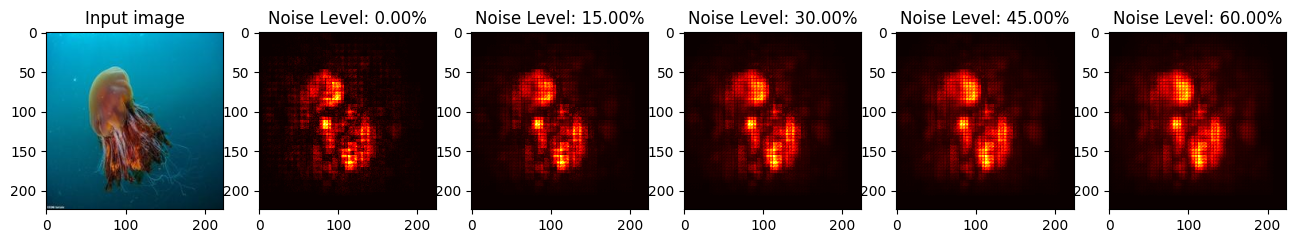

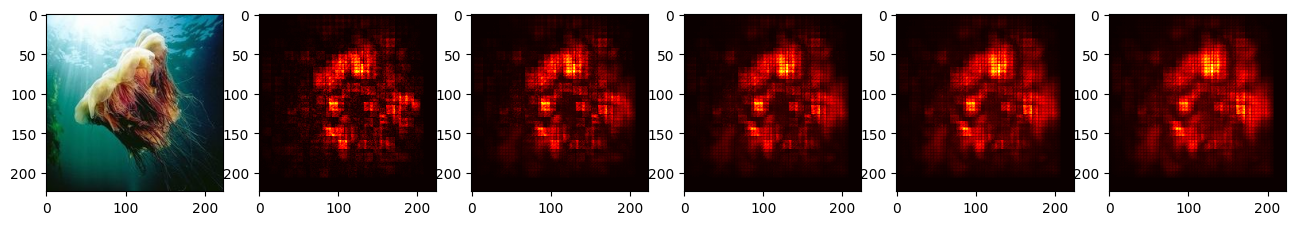

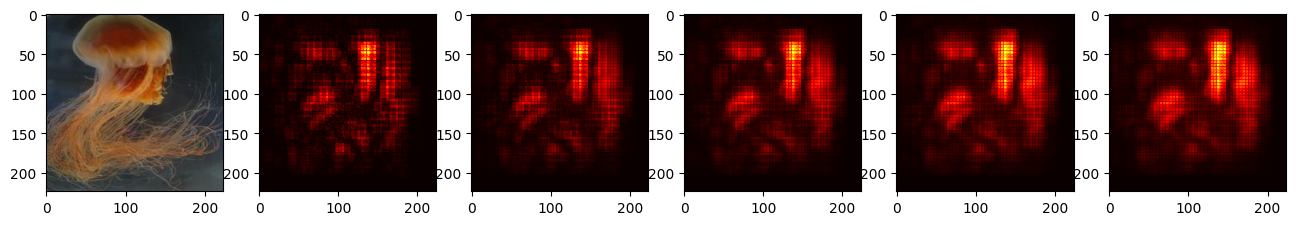

In [ ]:
for i in range(1,4):
    fig, axes = plt.subplots(1, 6, figsize=(16, 9))
    axes[0].imshow(images_samples[i,:,:,:])
    if i == 1:
      axes[0].set_title('Input image')
    for j in range(1,6):
        axes[j].imshow(SmoothGrad(model, images_samples[i,:,:,:], 0.15*(j-1), k=100)[0,:,:,0], cmap='hot')
        if i == 1:
          axes[j].set_title(f'Noise Level: {0.15*(j-1)*100:.2f}%')
    plt.show()

Looking at the new explanations we can actually says that the saliency maps show differences when increasing the noise, but at the same time the model must be sensitive to these noise since sometimes it gets amplified rather than being collapsed. However for a well-tuned model this procedure is more robust for example for image segmentation, since the smoother map shows more clearly the most important pixels.

### Global explanations

The previous exercises are examples of **local** explanations, where we try to interpret a single prediction of the network. Sometimes we are interested in **global** explanations, that try to find common patterns of behaviour. Suppose we have a dataset $\mathcal{T} = \left\{x_i\right\}$ of examples, we can compute some approximate global measure of influence by averaging their saliency:

$$
\text{GlobalSaliency} = \frac{1}{n} \sum_i S(x_i)
$$

To make this exercise more interesting, we will split it into 3 parts.


In [ ]:
# TODO: Write the required function, possibly avoding for-loops.

@tf.function
def ParallelMapping(model, samples):
        if isinstance(samples, tf.Tensor) == False:
            samples = tf.convert_to_tensor(samples)
        N = tf.cast(samples.shape[0], 'int32')
        with tf.GradientTape() as tape:
                tape.watch(samples)

                # Compute the prediction
                preds = model(samples)

                # Compute the predicted class
                C = tf.cast(tf.argmax(preds, axis=1),'int32')

                # Slice the indices to get a mask for preds
                indices = tf.transpose(tf.stack([tf.range(N), C]))

                # Return the abs of the gradient of the output with respect to the data point
                C_preds = tf.gather_nd(preds, indices)

                # Compute the tensor being the jacobian of the network with respect to the input samples
                return tf.math.abs(tape.batch_jacobian(tf.expand_dims(C_preds, axis=1), samples))

In [ ]:
# TODO: Write the required function.

def GlobalSaliency(model, samples):
    return tf.reduce_mean(ParallelMapping(model,samples), axis=0)

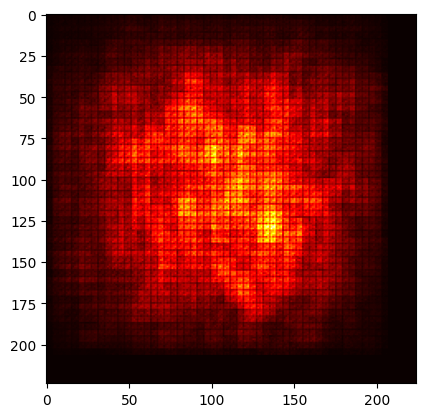

In [ ]:
glob_map = GlobalSaliency(model, images_samples)
plt.imshow(glob_map[0,:,:,0],cmap='hot')

Clearly in this case of image classification the global saliency shows no interesting result, but it could be useful for example for some tasks in pose estimation within subsequent frames: the global saliency map provides us with an estimate through different input of the activation, so it can provide meaningful insights if we inject temporal dependencies within images.

In this case we can't say anything more that the map shows a more accentuated activation in the center, as we expected from the images being more or less centered ones: let's have a look to our batch just to have an idea of what this global saliency tells us.

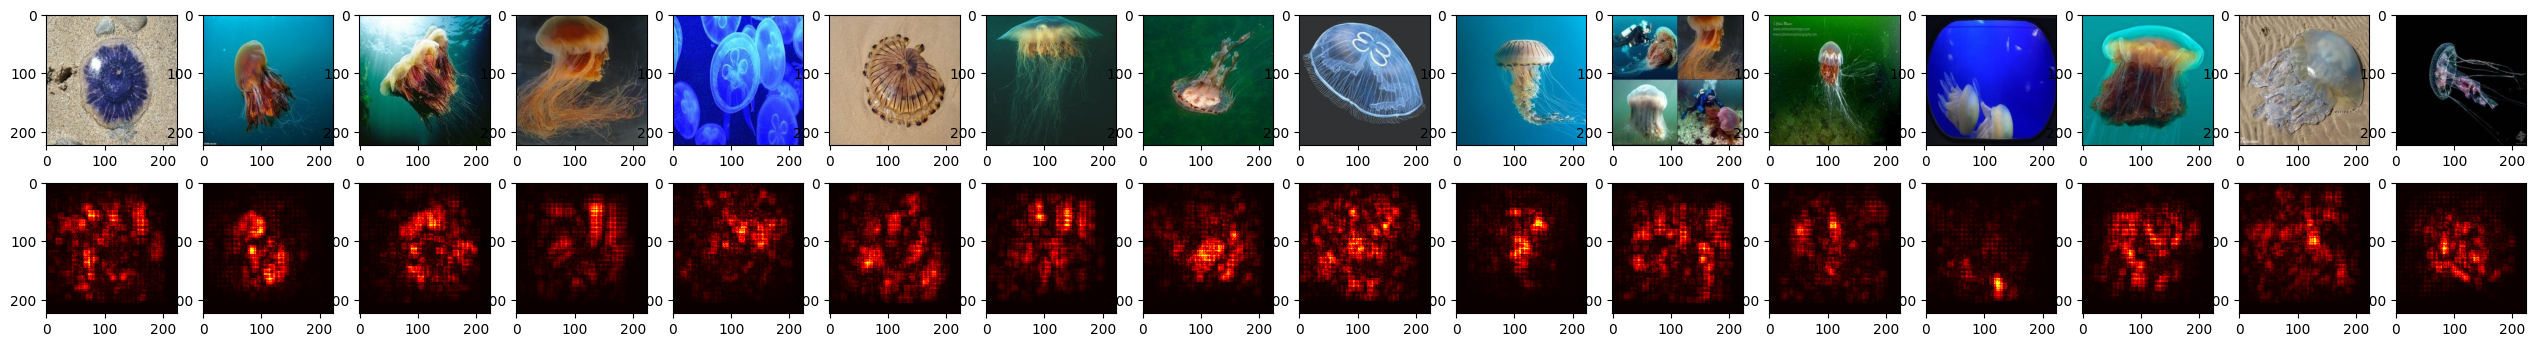

In [ ]:
fig, axes = plt.subplots(2, 16, figsize=(32, 4))
for i in range(0,16):
  axes[0,i].imshow(images_samples[i,:,:,:])
  axes[1,i].imshow(VanillaSaliencyMap(model, images_samples[i,:,:,:])[0,:,:,0], cmap='hot')

As expected the images are almost all centered in the frame, so in our case the global saliency can behave as a global estimator of some very high level description of our data.

In [ ]:
# Compare the results you obtained before with a simpler linear model.

number_classes = 6
batch_ = 32

linear_model = tf.keras.models.Sequential()
linear_model.add(keras.layers.Flatten(input_shape=(224, 224, 3)))
linear_model.add(keras.layers.Dense(number_classes, use_bias=True))
linear_model.add(keras.layers.Activation('softmax'))

linear_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.8,nesterov=True),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

linear_model.fit(train_generator, epochs=20, batch_size=batch_,verbose=1)

Epoch 1/20
23/23 [==============================] - 2s 55ms/step - loss: 116.4650 - categorical_accuracy: 0.2319
Epoch 2/20
23/23 [==============================] - 1s 54ms/step - loss: 82.9463 - categorical_accuracy: 0.3028
Epoch 3/20
23/23 [==============================] - 2s 82ms/step - loss: 62.8495 - categorical_accuracy: 0.3792
Epoch 4/20
23/23 [==============================] - 2s 71ms/step - loss: 48.9947 - categorical_accuracy: 0.4431
Epoch 5/20
23/23 [==============================] - 1s 55ms/step - loss: 65.0194 - categorical_accuracy: 0.3778
Epoch 6/20
23/23 [==============================] - 1s 55ms/step - loss: 41.1463 - categorical_accuracy: 0.4819
Epoch 7/20
23/23 [==============================] - 1s 54ms/step - loss: 51.1354 - categorical_accuracy: 0.4333
Epoch 8/20
23/23 [==============================] - 1s 53ms/step - loss: 55.6637 - categorical_accuracy: 0.4708
Epoch 9/20
23/23 [==============================] - 1s 62ms/step - loss: 33.9731 - categorical_accuracy

In this case our linear model is basically $f(x) = \phi(w^Tx + b)$, so in order to retrieve the weights we compute the derivative with respect to the input of the logits (output of the dense layer before the activation function) of the predicted classes.

In [ ]:
@tf.function
def LinearGlobalWeights(lin_model, samples):
        if isinstance(samples, tf.Tensor) == False:
          samples = tf.convert_to_tensor(samples)
        N = tf.cast(samples.shape[0], 'int32')
        with tf.GradientTape() as tape:
                tape.watch(samples)

                # Compute the logits
                logits = lin_model.layers[1](lin_model.layers[0](samples))

                # Compute the prediction
                preds = lin_model(samples)

                # Compute the predicted class
                C = tf.cast(tf.argmax(preds, axis=1),'int32')

                # Slice the indices to get a mask for preds
                indices = tf.transpose(tf.stack([tf.range(N), C]))

                # Return the abs of the gradient of the logits with respect to the data point
                C_logits = tf.gather_nd(logits, indices)

                # Compute the tensor being the jacobian of the network with respect to the input samples
                return tf.reduce_mean(tf.math.abs(tape.batch_jacobian(tf.expand_dims(C_logits, axis=1), samples)),axis=0)

Text(0.5, 1.0, 'GlobMap for linear model')

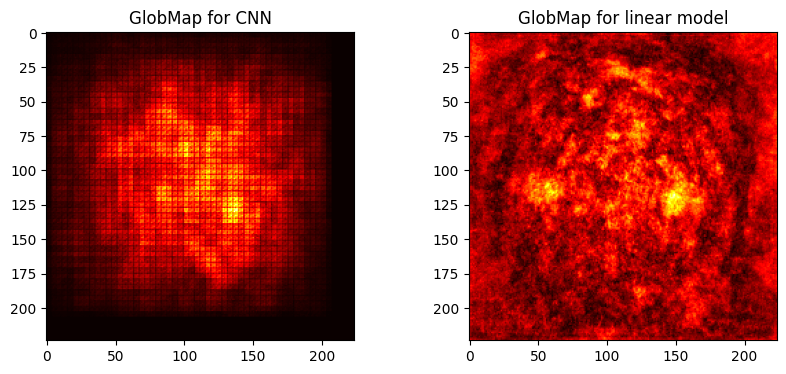

In [ ]:
linear_glob_map = LinearGlobalWeights(linear_model, images_samples)

figure, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(glob_map[0,:,:,0],cmap='hot')
axes[0].set_title('GlobMap for CNN')

axes[1].imshow(linear_glob_map[0,:,:,0],cmap='hot')
axes[1].set_title('GlobMap for linear model')

A linear model can hardly leverage any localty property in learning features when working on image, since it just collapse all the dimensions and treat the input just as a vector. At the same time, being the global saliency map much more messy, we can still see that some pixels in the middle show the highest activation.

### Integrated gradients

I implemented the integrated gradient as described in the linked paper, where on each dimension of the input we have:
\begin{equation}
  IntGrad_i(x) = (x_i - x'_i)\int_0^1 \frac{\partial f_c((1-\alpha)x' + \alpha x)}{\partial x_i} d \alpha
\end{equation}

Basically it integrates the gradient with respect to a parameter defining a convex combination between the input and a baseline input that for images can be the black image.
In this implementation the integral has been approximated through a finite sum in a for loop ranging on a tunable linspace on $[0,1]$.

In [ ]:
def IntegratedGradients(model, data_point, baseline = None, steps=100):

    # We need to expand dimension on the input data point to match first layer dimension (batch dimension)
    data_point = tf.expand_dims(data_point, axis=0)
    data_size = data_point.shape

    # Initialize a baseline
    if baseline != None:
      baseline = baseline
    else:
      baseline = tf.zeros(data_size)

    # Initialize a tensor to store the integrated gradients
    integrated_gradients = tf.zeros((data_size[1],data_size[2],data_size[3]))

    # Main loop
    for alpha in tf.linspace(0.0, 1.0, steps+1):

        # We need to istantiate a call to GradientTape and watch the input combo
        with tf.GradientTape() as tape:
            tape.watch(data_point)

            # Compute the convex combination between the data point and the baseline
            combo = alpha*data_point + (1-alpha)*baseline

            # Compute the prediction
            preds = model(combo)

            # Compute the predicted class
            C = int(tf.cast(tf.argmax(preds, axis=1)[0],'int32'))

            # Update the aggregator for the integrated gradient
            integrated_gradients += tf.math.abs(tape.gradient(preds[0,C],data_point))

    # Now average the whole procedure (discrete approximation of the integral)
    avg_gradients = integrated_gradients/steps
    return (data_point-baseline)*avg_gradients

Let's have a look comparing the integrated gradient with the vanilla saliency map:

Text(0.5, 1.0, 'Integrated Gradients')

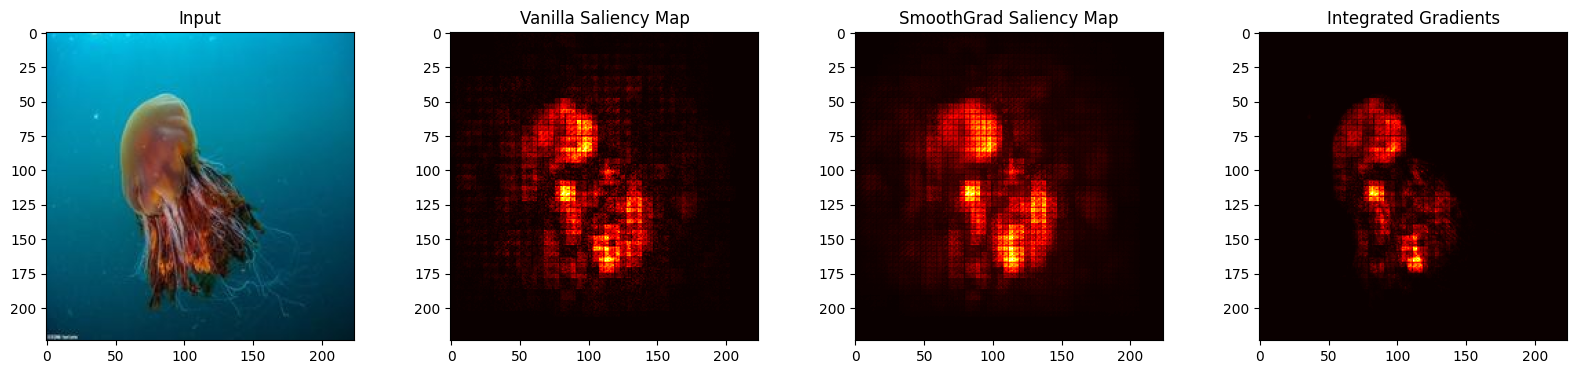

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].imshow(images_samples[1,:,:,:])
axes[0].set_title('Input')

axes[1].imshow(sal_map[0,:,:,0],cmap='hot')
axes[1].set_title('Vanilla Saliency Map')

axes[2].imshow(SmoothGrad(model, images_samples[1,:,:,:], 0.3, k=100)[0,:,:,0], cmap='hot')
axes[2].set_title('SmoothGrad Saliency Map')

axes[3].imshow(IntegratedGradients(model, images_samples[1,:,:,:])[0,:,:,0],cmap='hot')
axes[3].set_title('Integrated Gradients')

In an image segmentation perspective integrated gradients may get rid of noise better than vanilla saliency map and SmoothGrad saliency map.

### Bibliography

[1] Simonyan, K., Vedaldi, A. and Zisserman, A., 2013. [Deep inside convolutional networks: Visualising image classification models and saliency maps](https://arxiv.org/abs/1312.6034). arXiv preprint arXiv:1312.6034.

[2] Smilkov, D., Thorat, N., Kim, B., Viégas, F. and Wattenberg, M., 2017. [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825). arXiv preprint arXiv:1706.03825.

[3] Rudin, C., 2019. [Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead](https://www.nature.com/articles/s42256-019-0048-x). Nature Machine Intelligence, 1(5), pp. 206-215.

[4] Nguyen, G., Kim, D. and Nguyen, A., 2021. [The effectiveness of feature attribution methods and its correlation with automatic evaluation scores](https://proceedings.neurips.cc/paper/2021/hash/de043a5e421240eb846da8effe472ff1-Abstract.html). Advances in Neural Information Processing Systems, 34, pp.26422-26436.

[5] Pruthi, G., Liu, F., Kale, S. and Sundararajan, M., 2020. [Estimating training data influence by tracing gradient descent](https://proceedings.neurips.cc/paper/2020/hash/e6385d39ec9394f2f3a354d9d2b88eec-Abstract.html). Advances in Neural Information Processing Systems, 33, pp. 19920-19930.